## Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import GradientBoostingClassifier  
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, StratifiedKFold
from skopt import BayesSearchCV
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

## Load Dataset

In [2]:
df = pd.read_csv("The_Cancer_data_1500_V2.csv")

## Preview Dataset

In [3]:
rows, columns = df.shape
duplicate = df.duplicated().sum()
single_value = [x for x in df.columns if df[x].nunique() < 2]
boolean_like = [x for x in df.columns if df[x].dropna().nunique() == 2]
null_sum = df.isnull().sum().sum()

dtype_counts = df.dtypes.apply(lambda x: x.name).value_counts()
formatted_list = [f"{dtype}({count})" for dtype, count in dtype_counts.items()]
formattedd = ', '.join(formatted_list[:-1]) + ' and ' + formatted_list[-1] if len(formatted_list) > 1 else formatted_list[0]

def pluralize(word, count):
    return f"{count} {word}{'' if count == 1 else 's'}"

print(f"The Dataset contains {pluralize('Column', columns)} and {pluralize('Row', rows)}\n"
      f"The Data Types are {formattedd}\n"
      f"{pluralize('Row', duplicate)} consist of duplicate values\n"
      f"{pluralize('Column', len(single_value))} consist of a single value\n"
      f"{pluralize('Column', len(boolean_like))} consist of boolean-like values\n"
      f"{pluralize('Null value', null_sum)} are present")

df.head()

The Dataset contains 9 Columns and 1500 Rows
The Data Types are int64(6) and float64(3)
0 Rows consist of duplicate values
0 Columns consist of a single value
4 Columns consist of boolean-like values
0 Null values are present


,Age,Gender,BMI,Smoking,GeneticRisk,PhysicalActivity,AlcoholIntake,CancerHistory,Diagnosis
0,58,1,16.085313,0,1,8.146251,4.148219,1,1
1,71,0,30.828784,0,1,9.361630,3.519683,0,0
2,48,1,38.785084,0,2,5.135179,4.728368,0,1
3,34,0,30.040296,0,0,9.502792,2.044636,0,0
4,62,1,35.479721,0,0,5.356890,3.309849,0,1


In [4]:
df = df.rename(columns={"Gender": "Female"})

cols_to_bool = ['Female', 'Smoking', 'CancerHistory', 'Diagnosis']

for i in df.columns:
    if i in cols_to_bool:
        df[i] = df[i].astype(bool)
    elif i == 'GeneticRisk':
        df[i] = df[i].astype("category")

In [5]:
df['BMICategory'] = pd.cut(
    df['BMI'], 
    bins=[0, 18.5, 24.9, float('inf')], 
    labels=[0, 1, 2], 
    right=False
).astype(int).astype('category')


## Data Visualisation

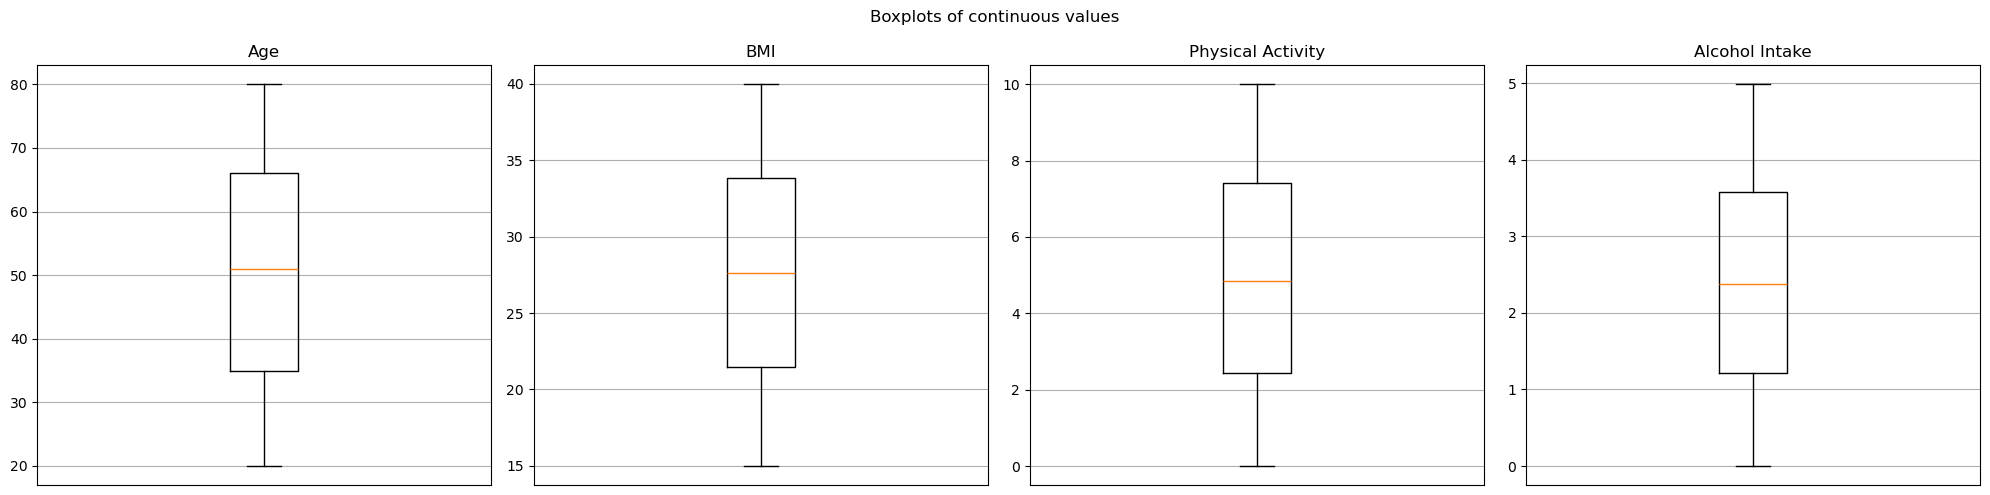

In [6]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # 1 row, 4 columns

# Age boxplot
axs[0].boxplot(df['Age'].dropna())
axs[0].set_title('Age')
axs[0].set_xticks([])  
axs[0].grid(True)

# BMI boxplot
axs[1].boxplot(df['BMI'].dropna())
axs[1].set_title('BMI')
axs[1].set_xticks([])  
axs[1].grid(True)

# PhysicalActivity boxplot
axs[2].boxplot(df['PhysicalActivity'].dropna())
axs[2].set_title('Physical Activity')
axs[2].set_xticks([])  
axs[2].grid(True)

# AlcoholIntake boxplot
axs[3].boxplot(df['AlcoholIntake'].dropna())
axs[3].set_title('Alcohol Intake')
axs[3].set_xticks([])  
axs[3].grid(True)

plt.suptitle('Boxplots of continuous values')
plt.tight_layout()
plt.show()


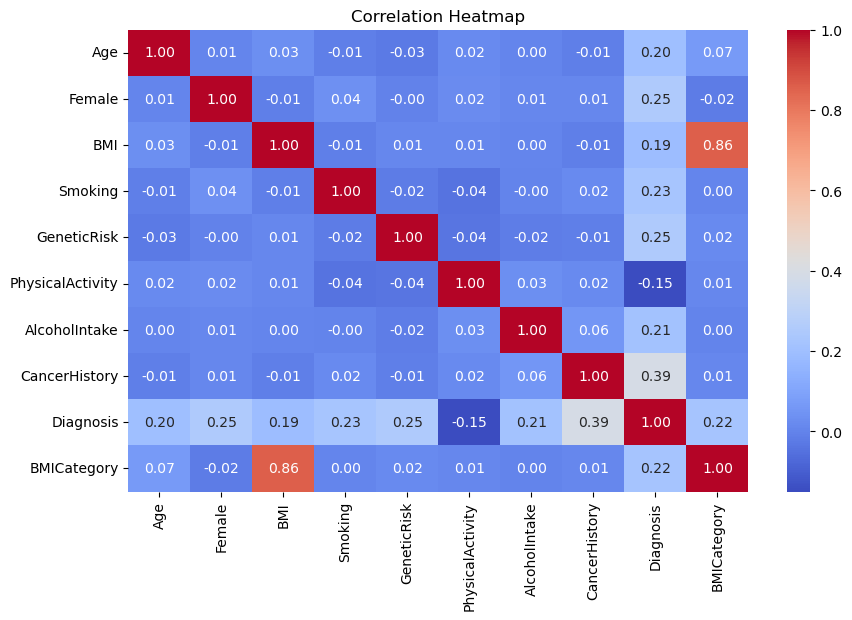

In [7]:
#Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


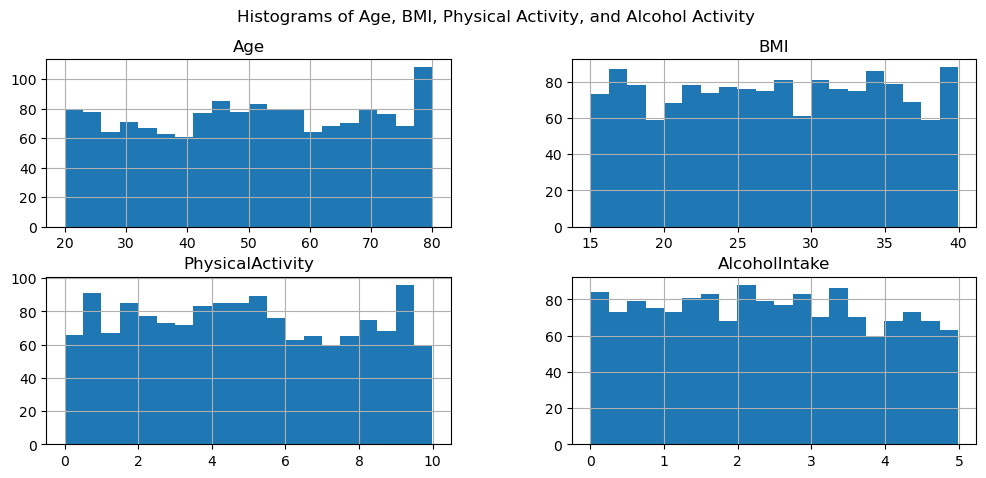

In [8]:
df[['Age', 'BMI', 'PhysicalActivity', 'AlcoholIntake']].hist(bins=20, figsize=(12, 5))
plt.suptitle('Histograms of Age, BMI, Physical Activity, and Alcohol Activity')
plt.show()


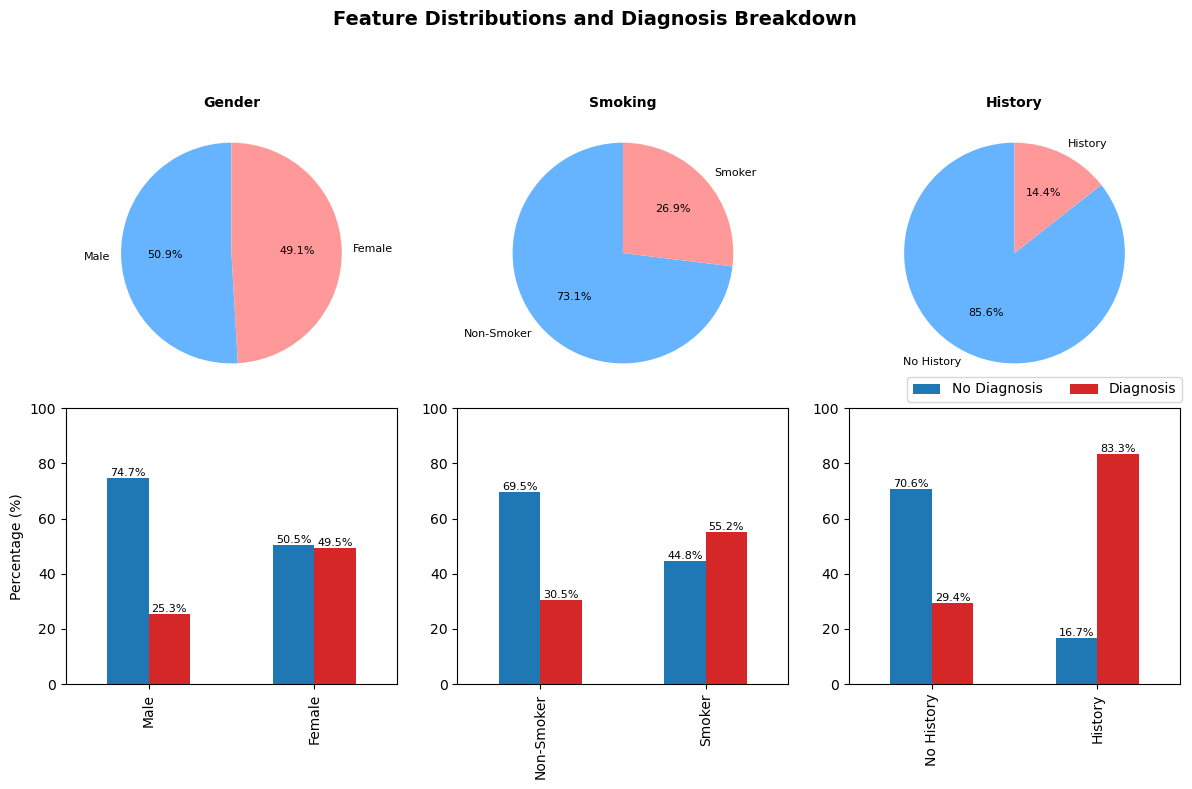

In [9]:
# Mapping feature names to readable labels
features = {
    'Female': ('Male', 'Female'),
    'Smoking': ('Non-Smoker', 'Smoker'),
    'CancerHistory': ('No History', 'History')
}

title_map = {
    'Female': 'Gender',
    'Smoking': 'Smoking',
    'CancerHistory': 'History'
}

# Color palettes
pie_colors = ['#66b3ff', '#ff9999']   # Soft blue, soft pink for pies
bar_colors = ['#1f77b4', '#d62728']   # Blue, red for bars

fig, axes = plt.subplots(2, len(features), figsize=(12, 8))

# ----- Row 1: Pie charts -----
for ax, (feature, labels) in zip(axes[0], features.items()):
    counts = df[feature].value_counts()
    counts.index = counts.index.map({False: labels[0], True: labels[1]})
    
    ax.pie(counts, labels=counts.index, autopct='%1.1f%%',
           startangle=90, colors=pie_colors, textprops={'fontsize': 8})
    ax.set_title(title_map[feature], fontsize=10, fontweight='bold')

# ----- Row 2: Bar charts -----
for ax, (feature, labels) in zip(axes[1], features.items()):
    counts = df.groupby([feature, 'Diagnosis']).size().unstack(fill_value=0)
    counts.index = counts.index.map({False: labels[0], True: labels[1]})
    
    perc = counts.div(counts.sum(axis=1), axis=0) * 100
    perc.plot(kind='bar', ax=ax, color=bar_colors, legend=False)
    
    ax.set_xlabel('')
    ax.set_ylim(0, 100)
    
    if ax == axes[1][0]:
        ax.set_ylabel('Percentage (%)')
    else:
        ax.set_ylabel('')
    
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.1f}%",
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', va='bottom', fontsize=8)

# ----- Custom legend BELOW pie charts -----
bar_legend_handles = [
    Patch(facecolor=bar_colors[0], label='No Diagnosis'),
    Patch(facecolor=bar_colors[1], label='Diagnosis')
]
fig.legend(
    handles=bar_legend_handles,
    loc='upper right',
    bbox_to_anchor=(.995, .53),  # Adjust vertical position between pie and bar rows
    ncol=2,
    fontsize=10
)

# ----- Figure title -----
fig.suptitle('Feature Distributions and Diagnosis Breakdown', fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


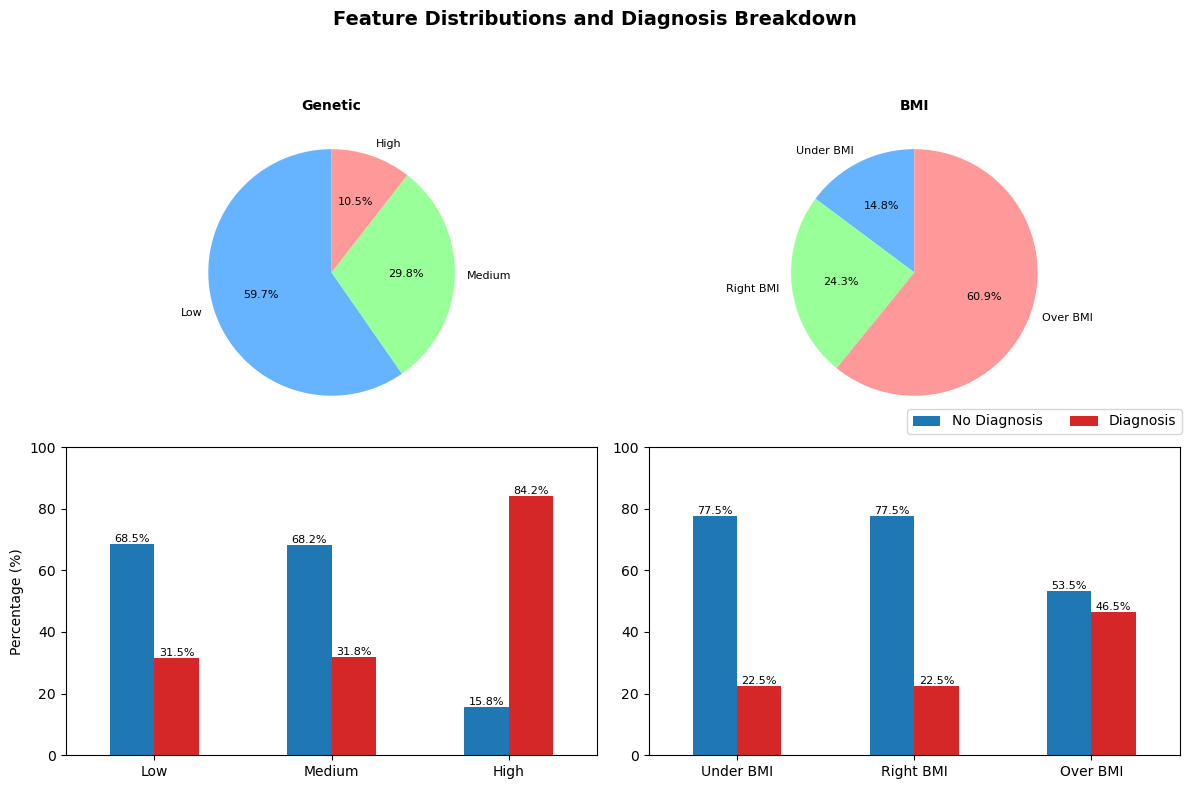

In [10]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

features = {
    'GeneticRisk': ('Low', 'Medium', 'High'),
    'BMICategory': ('Under BMI', 'Right BMI', 'Over BMI')
}

title_map = {
    'GeneticRisk': 'Genetic',
    'BMICategory': 'BMI'
}

pie_colors = ['#66b3ff', '#99ff99', '#ff9999']  # blue, green, pink
bar_colors = ['#1f77b4', '#d62728']             # blue, red

fig, axes = plt.subplots(2, len(features), figsize=(12, 8))

# ----- Row 1: Pie charts -----
for ax, (feature, labels) in zip(axes[0], features.items()):
    counts = df[feature].value_counts()
    counts.index = counts.index.map(lambda x: labels[x] if x in [0,1,2] else 'Unknown')
    counts = counts.reindex(labels).fillna(0)

    if counts.sum() == 0:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', fontsize=10)
        ax.set_title(title_map[feature], fontsize=10, fontweight='bold')
        ax.axis('off')
        continue

    ax.pie(counts, labels=counts.index, autopct='%1.1f%%',
           startangle=90, colors=pie_colors, textprops={'fontsize': 8})
    ax.set_title(title_map[feature], fontsize=10, fontweight='bold')

# ----- Row 2: Bar charts -----
for ax, (feature, labels) in zip(axes[1], features.items()):
    counts = df.groupby([feature, 'Diagnosis'], observed=True).size().unstack(fill_value=0)
    counts.index = counts.index.map(lambda x: labels[x] if x in [0,1,2] else 'Unknown')
    counts = counts.reindex(labels).fillna(0)

    perc = counts.div(counts.sum(axis=1), axis=0) * 100
    perc.plot(kind='bar', ax=ax, color=bar_colors, legend=False)

    ax.set_xlabel('')
    ax.set_ylim(0, 100)

    # Set x-axis tick labels explicitly
    ax.set_xticklabels(labels, rotation=0)

    if ax == axes[1][0]:
        ax.set_ylabel('Percentage (%)')
    else:
        ax.set_ylabel('')

    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.annotate(f"{height:.1f}%",
                        (p.get_x() + p.get_width() / 2, height),
                        ha='center', va='bottom', fontsize=8)

# ----- Custom legend BELOW pie charts -----
bar_legend_handles = [
    Patch(facecolor=bar_colors[0], label='No Diagnosis'),
    Patch(facecolor=bar_colors[1], label='Diagnosis')
]
fig.legend(
    handles=bar_legend_handles,
    loc='upper right',
    bbox_to_anchor=(.995, .49),
    ncol=2,
    fontsize=10
)

fig.suptitle('Feature Distributions and Diagnosis Breakdown', fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


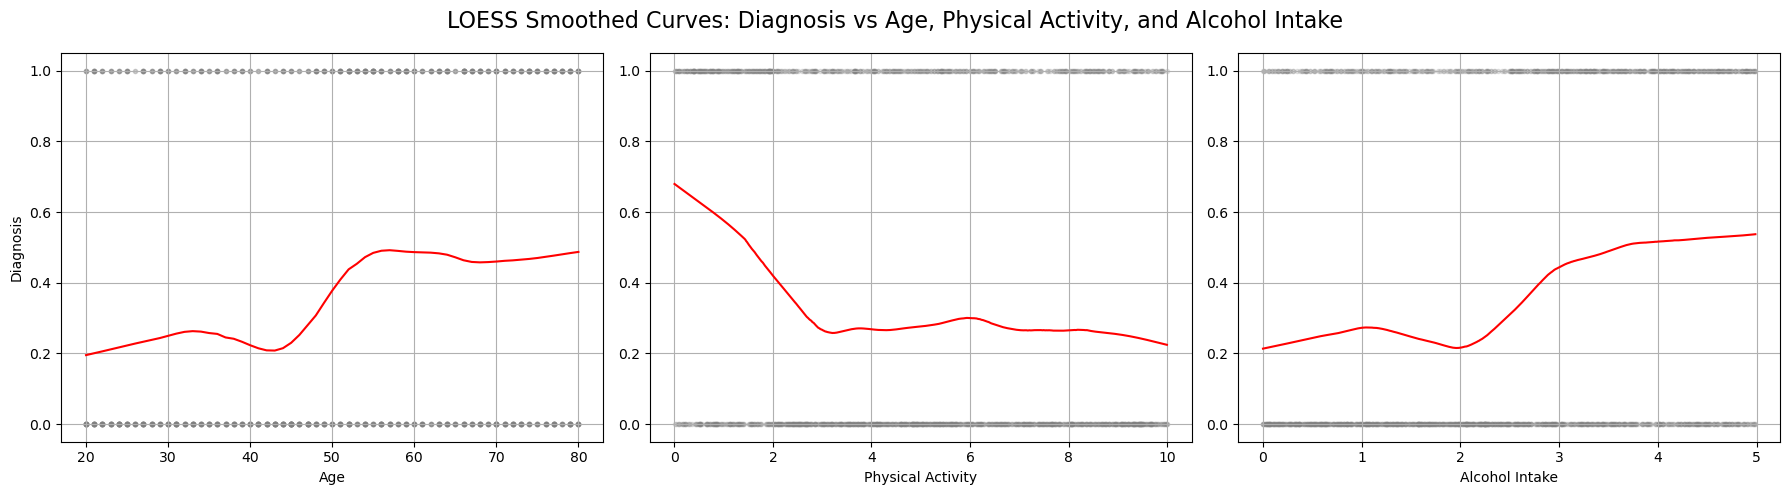

In [11]:
lowess = sm.nonparametric.lowess

fig, axs = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

# Age vs Diagnosis
smoothed_age = lowess(df['Diagnosis'], df['Age'], frac=0.3)
axs[0].scatter(df['Age'], df['Diagnosis'], alpha=0.2, c='gray', marker='.')
axs[0].plot(smoothed_age[:, 0], smoothed_age[:, 1], color='red')
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Diagnosis')
axs[0].grid(True)

# PhysicalActivity vs Diagnosis
smoothed_pa = lowess(df['Diagnosis'], df['PhysicalActivity'], frac=0.3)
axs[1].scatter(df['PhysicalActivity'], df['Diagnosis'], alpha=0.2, c='gray', marker='.')
axs[1].plot(smoothed_pa[:, 0], smoothed_pa[:, 1], color='red')
axs[1].set_xlabel('Physical Activity')
axs[1].grid(True)

# AlcoholIntake vs Diagnosis
smoothed_alc = lowess(df['Diagnosis'], df['AlcoholIntake'], frac=0.3)
axs[2].scatter(df['AlcoholIntake'], df['Diagnosis'], alpha=0.2, c='gray', marker='.')
axs[2].plot(smoothed_alc[:, 0], smoothed_alc[:, 1], color='red')
axs[2].set_xlabel('Alcohol Intake')
axs[2].grid(True)

fig.suptitle('LOESS Smoothed Curves: Diagnosis vs Age, Physical Activity, and Alcohol Intake', fontsize=16)
plt.tight_layout()
plt.show()


## Model Build

In [12]:
x = df.drop(columns=(['Diagnosis']))
y = df['Diagnosis']

In [13]:
xtrain, xtest, ytrain, ytest = train_test_split(x,y,random_state=70)

In [14]:
categorical_features = [int(xtrain.columns.get_loc(col)) for col in xtrain.select_dtypes(include=['object', 'category']).columns]

smote_nc = SMOTENC(categorical_features=categorical_features, random_state=70)
xtrain_smote, ytrain_smote = smote_nc.fit_resample(xtrain, ytrain)

before_counts = ytrain.value_counts().sort_index()
after_counts = pd.Series(ytrain_smote).value_counts().sort_index()

distribution_df = pd.DataFrame({
    'free_care_check_': before_counts.index,
    'Before': before_counts.values,
    'After': after_counts.values
})
distribution_df.index = distribution_df.index + 1
distribution_df

,free_care_check_,Before,After
1,False,707,707
2,True,418,707


In [15]:
continuous = df.select_dtypes(include=['float', 'int']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('minmax', MinMaxScaler(), continuous)
    ],
    remainder='passthrough'  # Keep other columns as-is
)

xtrain_scale = preprocessor.fit_transform(xtrain_smote)
xtest_scale = preprocessor.transform(xtest)


In [16]:
models = {
    'SVM': SVC(),
    'k-NN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(),
    'XGBoost': XGBClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(learning_rate=0.09487095651829398, max_depth=2,
                           min_samples_leaf=5, min_samples_split=5,
                           n_estimators=179)
}


scores = []

for name, model in models.items():
    model.fit(xtrain_scale, ytrain_smote)
    acc = model.score(xtest_scale, ytest)
    scores.append((name, model, acc))

scores.sort(key=lambda x: x[2], reverse=True)

for idx, (name, model, acc) in enumerate(scores, start=1):
    print(f"{idx}. {name} : {acc * 100:.2f}%")
    y_pred = model.predict(xtest_scale)
    print(classification_report(ytest, y_pred))

1. Gradient Boosting : 93.33%
              precision    recall  f1-score   support

       False       0.95      0.94      0.95       236
        True       0.91      0.91      0.91       139

    accuracy                           0.93       375
   macro avg       0.93      0.93      0.93       375
weighted avg       0.93      0.93      0.93       375

2. XGBoost : 92.27%
              precision    recall  f1-score   support

       False       0.93      0.94      0.94       236
        True       0.90      0.88      0.89       139

    accuracy                           0.92       375
   macro avg       0.92      0.91      0.92       375
weighted avg       0.92      0.92      0.92       375

3. Random Forest : 91.20%
              precision    recall  f1-score   support

       False       0.94      0.92      0.93       236
        True       0.87      0.89      0.88       139

    accuracy                           0.91       375
   macro avg       0.90      0.91      0.91       37

In [17]:
param_space = {
    'n_estimators': (170, 180),
    'learning_rate': (0.085, 0.095),
    'max_depth': [2],
    'min_samples_split': [5],
    'min_samples_leaf': [5]
}

bayes_search = BayesSearchCV(
    estimator=GradientBoostingClassifier(),
    search_spaces=param_space,
    n_iter=20,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    random_state=42
)

bayes_search.fit(xtrain_scale, ytrain_smote)
best_params = bayes_search.best_params_
best_model = GradientBoostingClassifier(**best_params)
best_model.fit(xtrain_scale, ytrain_smote)

GradientBoostingClassifier(learning_rate=0.09312395988357364, max_depth=2,
                           min_samples_leaf=5, min_samples_split=5,
                           n_estimators=175)

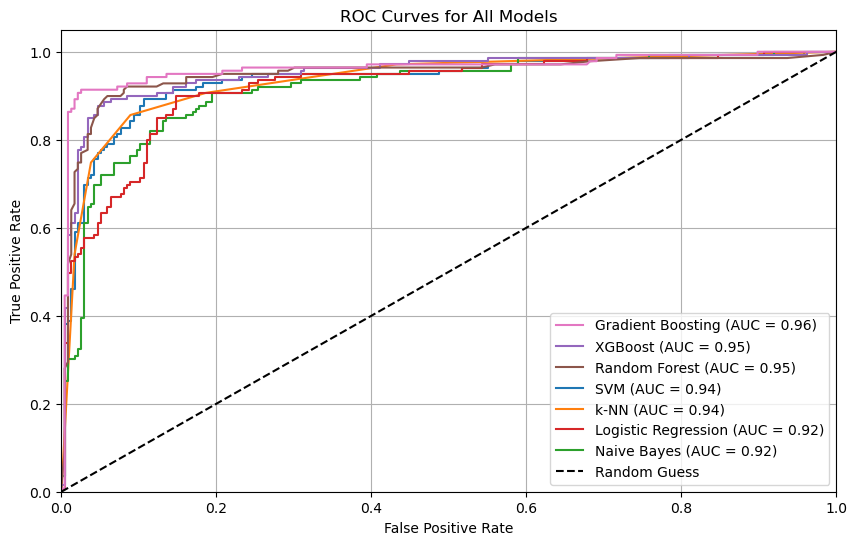

In [18]:
# Ensure SVM allows probability predictions
models['SVM'] = SVC(probability=True)

roc_data = []

# Fit models and collect ROC curve data
for name, model in models.items():
    model.fit(xtrain_scale, ytrain_smote)
    
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(xtest_scale)[:, 1]
    else:
        y_scores = model.decision_function(xtest_scale)
    
    fpr, tpr, _ = roc_curve(ytest, y_scores)
    roc_auc = auc(fpr, tpr)
    roc_data.append((name, fpr, tpr, roc_auc))

# Plot ROC curves (original order for colors)
plt.figure(figsize=(10, 6))
handles = []
labels = []

for name, fpr, tpr, roc_auc in roc_data:
    line, = plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    handles.append(line)
    labels.append(f'{name} (AUC = {roc_auc:.2f})')

# Sort legend by AUC descending
roc_data_sorted = sorted(zip(handles, labels, roc_data), key=lambda x: x[2][3], reverse=True)
sorted_handles = [h for h, _, _ in roc_data_sorted]
sorted_labels = [l for _, l, _ in roc_data_sorted]

# Random guess line
rand_line, = plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
sorted_handles.append(rand_line)
sorted_labels.append('Random Guess')

# Apply sorted legend
plt.legend(sorted_handles, sorted_labels, loc='lower right')

# Chart settings
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.grid(True)
plt.show()


## Conclusion

In this cancer prediction task, the top three performers—**Gradient Boosting** (93.33%), **XGBoost** (92.27%), and **Random Forest** (91.47%)—stand out as the most accurate and reliable models. All three consistently deliver high precision, recall, and F1-scores across both cancer-positive and cancer-negative cases, indicating strong predictive power without significant bias toward one outcome. Their ability to capture complex non-linear relationships and interactions between medical features makes them well-suited for this problem, where subtle patterns can be critical for accurate diagnosis. Among them, Gradient Boosting achieves the highest accuracy, making it the most effective choice for maximizing prediction performance in this application.
